In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

In [2]:
pd.options.mode.chained_assignment = None

Now that I have validated the model, I will use it to demostrate some of it's capabilities by predicting home values across the entire dataset. 

In [3]:
X = pd.read_csv('data/independent_vars.csv')
y = pd.read_csv('data/dependent_var.csv')
X.drop('Unnamed: 0', axis = 1, inplace = True)
y.drop('Unnamed: 0', axis = 1, inplace = True)

linreg = LinearRegression()
model = linreg.fit(X,y)

In [4]:
scaled_pred_price = model.predict(X)
pred_price = scaled_pred_price

In [5]:
data = pd.read_csv('data/clean_housing.csv')

#Reverse the scaling of the price used in the model.
data['pred_price'] = (pred_price*185546)+451089

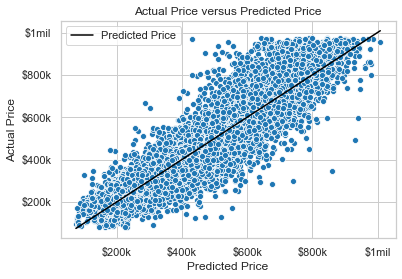

In [6]:
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.title('Actual Price versus Predicted Price')
sns.scatterplot(x='pred_price', y='price', data = data)
sns.lineplot(x='pred_price', y='pred_price', data = data, 
             color = 'black', label = 'Predicted Price')
plt.legend()
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.yticks(ticks=(200000, 400000, 600000, 800000, 1000000), 
           labels= ('$200k', '$400k', 
                    '$600k', '$800k', '$1mil'))
plt.xticks(ticks=(200000, 400000, 600000, 800000, 1000000), 
           labels= ('$200k', '$400k', 
                    '$600k', '$800k', '$1mil'))
plt.savefig('figures/figure1.png');

To begin showcasing the capabilities of this model, I will isolate the impact of each target independent variable by imputing the mean of each column for the remaining values.

In [7]:
def isolate(iso, n_rows):
    mean_df = X.loc[:n_rows - 1]
    iso_series = np.linspace(X[iso].min(), 
                             X[iso].max(), n_rows)
    for col in X.columns:
        mean_df.loc[:, col] = X[col].mean()
    mean_df.loc[:, iso] = iso_series
    return mean_df

## Question 1
Impact of month on housing prices.

In [8]:
iso_month = isolate('month_sold', 12)

In [9]:
iso_month.head()

,Bellevue,Seattle,sqft_living15,sqft_living,lat * dist_to_Seattle,lat,grade,age,view,sqft_living * Seattle,...,sqft_living * Kent^3,lat * dist_to_Seattle^2,lat^3,dist_to_Seattle^3,long^3,view^4,view^2,grade^3,lat^2,lat * Bellevue^2
0,0.253367,0.386139,-9.012326e-17,7.332756e-18,-0.633658,-2.050265e-12,-7.841393e-15,2.435718e-15,1.297567e-15,-0.127834,...,0.066826,1.766072,-0.453705,0.63329,0.773581,24.7953,0.999939,0.394302,0.999939,0.177068
1,0.253367,0.386139,-9.012326e-17,7.332756e-18,-0.633658,-2.050265e-12,-7.841393e-15,2.435718e-15,1.297567e-15,-0.127834,...,0.066826,1.766072,-0.453705,0.63329,0.773581,24.7953,0.999939,0.394302,0.999939,0.177068
2,0.253367,0.386139,-9.012326e-17,7.332756e-18,-0.633658,-2.050265e-12,-7.841393e-15,2.435718e-15,1.297567e-15,-0.127834,...,0.066826,1.766072,-0.453705,0.63329,0.773581,24.7953,0.999939,0.394302,0.999939,0.177068
3,0.253367,0.386139,-9.012326e-17,7.332756e-18,-0.633658,-2.050265e-12,-7.841393e-15,2.435718e-15,1.297567e-15,-0.127834,...,0.066826,1.766072,-0.453705,0.63329,0.773581,24.7953,0.999939,0.394302,0.999939,0.177068
4,0.253367,0.386139,-9.012326e-17,7.332756e-18,-0.633658,-2.050265e-12,-7.841393e-15,2.435718e-15,1.297567e-15,-0.127834,...,0.066826,1.766072,-0.453705,0.63329,0.773581,24.7953,0.999939,0.394302,0.999939,0.177068


In [10]:
iso_month.loc[:, 'month_sold^3'] = iso_month['month_sold']**3

In [11]:
iso_month[['month_sold', 'month_sold^3']]

,month_sold,month_sold^3
0,-1.788865,-5.724438
1,-1.468173,-3.164692
2,-1.147480,-1.510899
3,-0.826788,-0.565174
4,-0.506095,-0.129627
5,-0.185403,-0.006373
6,0.135290,0.002476
7,0.455983,0.094808
8,0.776675,0.468509
9,1.097368,1.321467


In [12]:
y_pred = model.predict(iso_month)
pred_price = (y_pred*185546)+451089

In [13]:
Month_data = pd.DataFrame(['Jan', 'Feb', 'Mar', 'Apr',
                           'May', 'Jun', 'Jul', 'Aug',
                           'Sep', 'Oct', 'Nov', 'Dec'])

In [14]:
Month_data['Predicted Price'] = pred_price

In [15]:
Month_data['Average Price'] = 451089

In [16]:
Month_data

,0,Predicted Price,Average Price
0,Jan,451459.395929,451089
1,Feb,460144.173229,451089
2,Mar,463619.830213,451089
3,Apr,463024.193537,451089
4,May,459495.089859,451089
5,Jun,454170.345834,451089
6,Jul,448187.788120,451089
7,Aug,442685.243373,451089
8,Sep,438800.538251,451089
9,Oct,437671.499410,451089


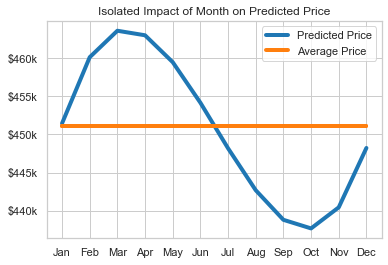

In [17]:
sns.lineplot(x=0, y='Predicted Price', data=Month_data, 
             sort = False, label='Predicted Price', 
             linewidth=4)
sns.lineplot(x=0, y='Average Price', data=Month_data, 
             label='Average Price', linewidth=4)
plt.title('Isolated Impact of Month on Predicted Price')
plt.xlabel('')
plt.ylabel('')
plt.yticks(ticks=(440000, 445000, 450000, 455000, 460000), 
                  labels= ('$440k', '$445k', '$450k', 
                  '$455k', '$460k'))
plt.savefig('figures/figure2.png');

In [18]:
(Month_data['Predicted Price'].max()
 - Month_data['Average Price'].median())

12530.830213207519

In [19]:
(Month_data['Predicted Price'].min()
 - Month_data['Average Price'].median())

-13417.500589534116

## Question 2
Impact of increasing number of interested buyers.

In [20]:
X['view'].value_counts()

-0.232946    15306
 3.528665      522
 1.647859      194
 5.409471      180
 7.290277       59
Name: view, dtype: int64

In [21]:
data['view'].value_counts()

0.0    15306
2.0      522
1.0      194
3.0      180
4.0       59
Name: view, dtype: int64

In [22]:
iso_view = isolate('view', 5)

In [23]:
iso_view.loc[:, 'view^2'] = iso_view['view']**2
iso_view.loc[:, 'view^4'] = iso_view['view']**4

In [24]:
y_pred = model.predict(iso_view)
pred_price = (y_pred*185546)+451089

In [25]:
view_data = pd.DataFrame(['0', '1', '2', '3', '4'])

In [26]:
view_data['Predicted Price'] = pred_price

In [27]:
view_data['Average Price'] = 451089

In [28]:
view_data

,0,Predicted Price,Average Price
0,0,447836.449338,451089
1,1,488889.552307,451089
2,2,494786.167244,451089
3,3,509090.303246,451089
4,4,607022.515136,451089


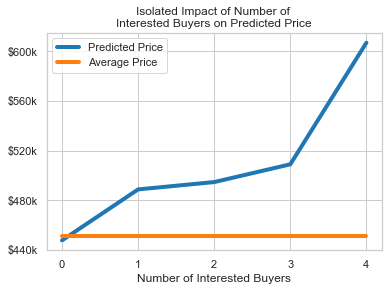

In [29]:
sns.lineplot(x=0, y='Predicted Price', data=view_data, 
             sort = False, label='Predicted Price', 
             linewidth=4)
sns.lineplot(x=0, y='Average Price', data=view_data, 
             label='Average Price', linewidth=4)
plt.xlabel('Number of Interested Buyers')
plt.ylabel('')
plt.yticks(ticks=(440000, 480000, 520000, 560000, 600000), 
                  labels= ('$440k', '$480k', '$520k', 
                  '$560k', '$600k'))
plt.title('''Isolated Impact of Number of 
Interested Buyers on Predicted Price''')
plt.savefig('figures/figure3.png');

In [30]:
(view_data['Predicted Price'].max()
 - view_data['Average Price'].median())

155933.5151356446

In [31]:
(view_data['Predicted Price'].min()
 - view_data['Average Price'].median())

-3252.5506615877966

## Question 3
Impact of Renovation

In [32]:
iso_ren = isolate('Renovated', 2)

In [33]:
y_pred = model.predict(iso_ren)
pred_price = (y_pred*185546)+451089

In [34]:
ren_data = pd.DataFrame(['Not', 'Renovated'])

In [35]:
ren_data['Predicted Price'] = pred_price

In [36]:
ren_data['Average Price'] = 451089

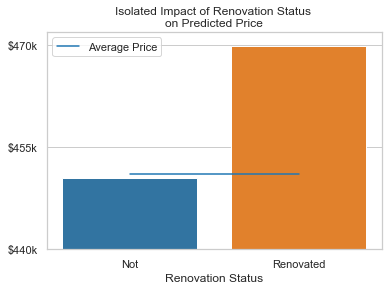

In [37]:
sns.barplot(x=0, y='Predicted Price', data=ren_data)
sns.lineplot(x=0, y='Average Price', data=ren_data, 
             label='Average Price')
plt.xlabel('Renovation Status')
plt.ylabel('')
plt.yticks(ticks=(440000, 455000, 470000), 
           labels=('$440k', '$455k', '$470k'))
plt.title('''Isolated Impact of Renovation Status 
on Predicted Price''')
plt.ylim(bottom = 440000, top = 472000)
plt.savefig('figures/figure4.png');

In [38]:
(ren_data['Predicted Price'].max()
 - ren_data['Average Price'].median())

18824.777356249513

In [39]:
(ren_data['Predicted Price'].min()
 - ren_data['Average Price'].median())

-529.6551545023103

## Question 4
Impact of square footage.

In [40]:
data['sqft_living'].describe()

count    16261.000000
mean      1843.576902
std        671.424738
min        370.000000
25%       1340.000000
50%       1750.000000
75%       2260.000000
max       4940.000000
Name: sqft_living, dtype: float64

In [41]:
iso_size = isolate('sqft_living', 4570)

In [42]:
iso_size.loc[:, 'sqft_living * Seattle'] = iso_size['sqft_living']*iso_size['Seattle']
iso_size.loc[:, 'sqft_living * Seattle^3'] = (iso_size['sqft_living']*iso_size['Seattle'])**3
iso_size.loc[:, 'sqft_living^3'] = iso_size['sqft_living']**3

In [43]:
y_pred = model.predict(iso_size)
pred_price = (y_pred*185546)+451089

In [44]:
size_data = pd.DataFrame(range(370, 4940))

In [45]:
size_data['Predicted Price'] = pred_price

In [46]:
size_data['Average Price'] = 451089

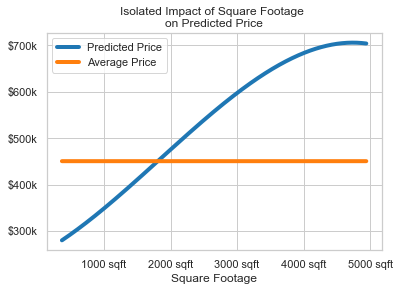

In [47]:
sns.lineplot(x=0, y='Predicted Price', 
             data=size_data, label = 'Predicted Price', 
             linewidth=4)
sns.lineplot(x=0, y='Average Price', 
             data=size_data, label = 'Average Price', 
             linewidth=4)
plt.xlabel('Square Footage')
plt.ylabel('')
plt.yticks(ticks=(300000, 400000, 500000, 600000, 700000), 
           labels=('$300k', '$400k', '$500k', 
                   '$600k', '$700k'))
plt.xticks(ticks=(1000, 2000, 3000, 4000, 5000), 
           labels=('1000 sqft', '2000 sqft', '3000 sqft', 
                   '4000 sqft', '5000 sqft'))
plt.title('''Isolated Impact of Square Footage 
on Predicted Price''')
plt.savefig('figures/figure5.png');

In [48]:
size_data[size_data[0]==2000]['Predicted Price']

1630    475858.237717
Name: Predicted Price, dtype: float64

In [49]:
size_data[size_data[0]==2100]['Predicted Price']

1730    488771.370038
Name: Predicted Price, dtype: float64

In [50]:
475858.24 - 488771.37

-12913.130000000005

In [51]:
size_data[size_data['Predicted Price']
          == size_data['Predicted Price'].max()][0]

4368    4738
Name: 0, dtype: int64

## Question 5
What Kind of Additions?

In [52]:
data['bathrooms'].value_counts()

2.50    4149
1.00    3399
1.75    2409
2.00    1568
2.25    1540
1.50    1239
2.75     778
3.00     447
3.50     337
3.25     276
0.75      42
3.75      38
4.00      28
1.25       7
0.50       4
Name: bathrooms, dtype: int64

In [53]:
iso_beds = isolate('bathrooms', 8)

In [54]:
X['bedrooms^4'].value_counts()

0.008614     7841
0.727945     4864
5.522646     2437
21.447931     961
58.138489     158
Name: bedrooms^4, dtype: int64

In [55]:
data['bedrooms'].value_counts()

3    7841
4    4864
2    2437
5     961
1     158
Name: bedrooms, dtype: int64

In [56]:
one_bed = iso_beds.copy()
one_bed['bedrooms^4'] = 58.138489 
two_bed = iso_beds.copy()
two_bed['bedrooms^4'] = 5.522646
three_bed = iso_beds.copy()
three_bed['bedrooms^4'] = .008614
four_bed = iso_beds.copy()
four_bed['bedrooms^4'] = .727945
five_bed = iso_beds.copy()
five_bed['bedrooms^4'] = 21.447931

beds = [one_bed, two_bed, three_bed, four_bed, five_bed]
rooms = pd.DataFrame()
for i in beds:
    rooms = rooms.append(i)
    
y_pred = model.predict(rooms)
pred_price = (y_pred*185546)+451089

In [57]:
room_data = pd.DataFrame(np.linspace(.5, 4, 8))

one_bed = room_data.copy()
one_bed['bedrooms'] = 1 
two_bed = room_data.copy()
two_bed['bedrooms'] = 2
three_bed = room_data.copy()
three_bed['bedrooms'] = 3
four_bed = room_data.copy()
four_bed['bedrooms'] = 4
five_bed = room_data.copy()
five_bed['bedrooms'] = 5

beds = [one_bed, two_bed, three_bed, four_bed, five_bed]
rooms = pd.DataFrame()
for i in beds:
    rooms = rooms.append(i)
    
rooms['Predicted Price'] = pred_price
rooms['Average Price'] = 451089
rooms['Number of Bathrooms']= rooms[0]

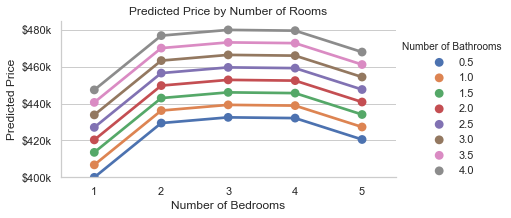

In [58]:
sns.catplot(x='bedrooms', y='Predicted Price', 
            hue='Number of Bathrooms', 
            data = rooms, legend_out=True, kind='point',
            height=3, aspect=2, palette='deep')
plt.title('Predicted Price by Number of Rooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Predicted Price')
plt.yticks(ticks=(400000, 420000, 440000, 460000, 480000), 
           labels=('$400k', '$420k', '$440k', 
                   '$460k', '$480k'))
plt.ylim(bottom=400000, top = 485000)
plt.savefig('figures/figure6.png');

In [59]:
rooms[:9]

,0,bedrooms,Predicted Price,Average Price,Number of Bathrooms
0,0.5,1,399972.376392,451089,0.5
1,1.0,1,406753.709914,451089,1.0
2,1.5,1,413535.043436,451089,1.5
3,2.0,1,420316.376957,451089,2.0
4,2.5,1,427097.710479,451089,2.5
5,3.0,1,433879.044001,451089,3.0
6,3.5,1,440660.377523,451089,3.5
7,4.0,1,447441.711045,451089,4.0
0,0.5,2,429450.328890,451089,0.5


In [60]:
399972-429450

-29478

In [61]:
399972-406753

-6781

## Question 6
Best time to invest.

In [62]:
data['age'].describe()

count    16261.000000
mean        44.345797
std         30.288348
min         -1.000000
25%         16.000000
50%         44.000000
75%         65.000000
max        115.000000
Name: age, dtype: float64

In [63]:
iso_age = isolate('age', 116)

In [64]:
iso_age.loc[:, 'age^2'] = iso_age['age']**2
iso_age.loc[:, 'age^3'] = iso_age['age']**3

In [65]:
y_pred = model.predict(iso_age)
pred_price = (y_pred*185546)+451089

In [66]:
age_data = pd.DataFrame(range(0,116))

In [67]:
age_data['Predicted Price'] = pred_price

In [68]:
age_data['Average Price'] = 451089

In [69]:
age_data

,0,Predicted Price,Average Price
0,0,457239.066268,451089
1,1,454194.837059,451089
2,2,451309.169794,451089
3,3,448579.335090,451089
4,4,446002.603560,451089
...,...,...,...
111,111,481931.841475,451089
112,112,479825.094882,451089
113,113,477573.948538,451089
114,114,475175.673060,451089


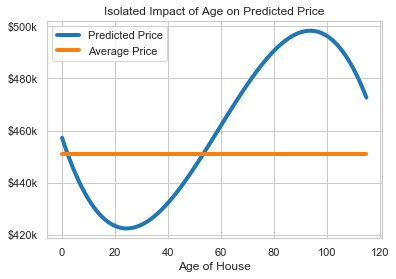

In [70]:
sns.lineplot(x=0, y='Predicted Price', data=age_data, 
             linewidth=4, label='Predicted Price')
sns.lineplot(x=0, y='Average Price', data=age_data, 
             linewidth=4, label='Average Price')
plt.title('Isolated Impact of Age on Predicted Price')
plt.yticks(ticks=(420000, 440000, 460000, 480000, 500000), 
           labels=('$420k', '$440k', '$460k', 
                   '$480k', '$500k'))
plt.xlabel('Age of House')
plt.ylabel('')
plt.savefig('figures/figure7.png');

In [71]:
low = age_data['Predicted Price'].min()
age_data[age_data['Predicted Price']==low][0]

24    24
Name: 0, dtype: int64

In [72]:
high = age_data['Predicted Price'].max()
age_data[age_data['Predicted Price']==high][0]

94    94
Name: 0, dtype: int64